# Принятие решений в бизнесе

# Описание проекта
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. 
Цели:
- Приоритизируйте гипотезы
- Запустите A/B-тест 
- Проанализируйте результаты.

# Описание данных
Данные для первой части
Файл hypothesis.csv. 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
Данные для второй части
Файл orders.csv.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.
Файл visitors.csv.
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('hypothesis.csv')  

try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('orders.csv')

try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('visitors.csv')

### Обработаем датасет Hypothesis

In [3]:
pd.options.display.max_colwidth = 100
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.columns = map(str.lower, hypothesis.columns)

### Обработаем датасеты Orders и Visits

In [5]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [8]:
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

In [9]:
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [10]:
orders.duplicated().sum()

0

In [11]:
orders['visitor_id'].nunique()

1031

In [12]:
dupl_list= orders.groupby('visitor_id')['group'].nunique().reset_index().query('group>1')

In [13]:
orders_filt = orders[~orders.visitor_id.isin(dupl_list['visitor_id'])]

In [14]:
orders_filt['visitor_id'].nunique()

973

In [15]:
orders_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1016 non-null   int64 
 1   visitor_id      1016 non-null   int64 
 2   date            1016 non-null   object
 3   revenue         1016 non-null   int64 
 4   group           1016 non-null   object
dtypes: int64(3), object(2)
memory usage: 47.6+ KB


In [16]:
orders_filt['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

In [17]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [18]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [19]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [20]:
visitors.duplicated().sum()

0

In [21]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [22]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [23]:
orders_filt['date'] = orders_filt['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

C:\Temp\ipykernel_1976\173795622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_filt['date'] = orders_filt['date'].map(


**Датасеты обработаны. Пропуски не обнаружены. Так же рассмотрели наличие пользователей попавших в обе группы в датасете orders, и создали отфильтрованный датасет orders_filt. Для датасета visits такую процедуру проделать невозможно т.к. там собраны кумулитивные значения.**

## Приоритизация гипотез

### Применим фреймворк ICE для приоритизации гипотез. 

In [24]:
hypothesis['ice'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)
hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Наиболее перспективные гипотезвы по ICE:8,0,7,6.**

### Применим фреймворк RICE для приоритизации гипотез. 

In [25]:
hypothesis['rice'] = round(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)
hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Наиболее перспективные гипотезвы по RICE: 7,2,0,6. Смена позиций произошла по причине учета показателя Reach, который показывает охват пользователей.**

## Анализ A/B-теста

### График кумулятивной выручки по группам

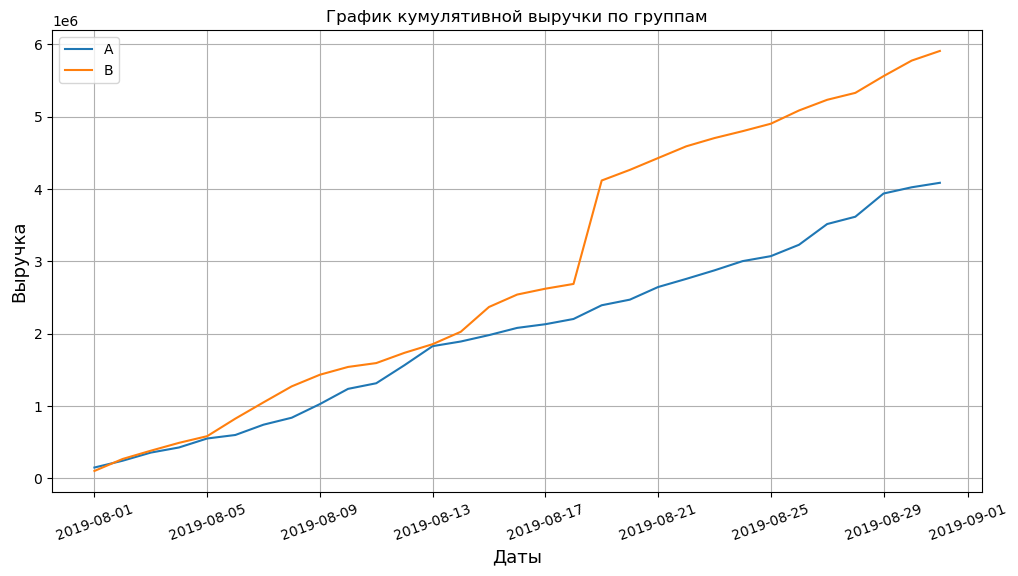

In [26]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 6))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')


plt.legend()
plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=20)
plt.xlabel('Даты',fontsize=13)
plt.ylabel('Выручка',fontsize=13);

**Выручка постоянно растет и это хорошо. Тест В практически сразу выходит вперед, и продолжает лидировать. Так же стоит отметить резкий всплеск 18.08, похоже на какой-то аномально большой заказ.**

### График кумулятивного среднего чека по группам

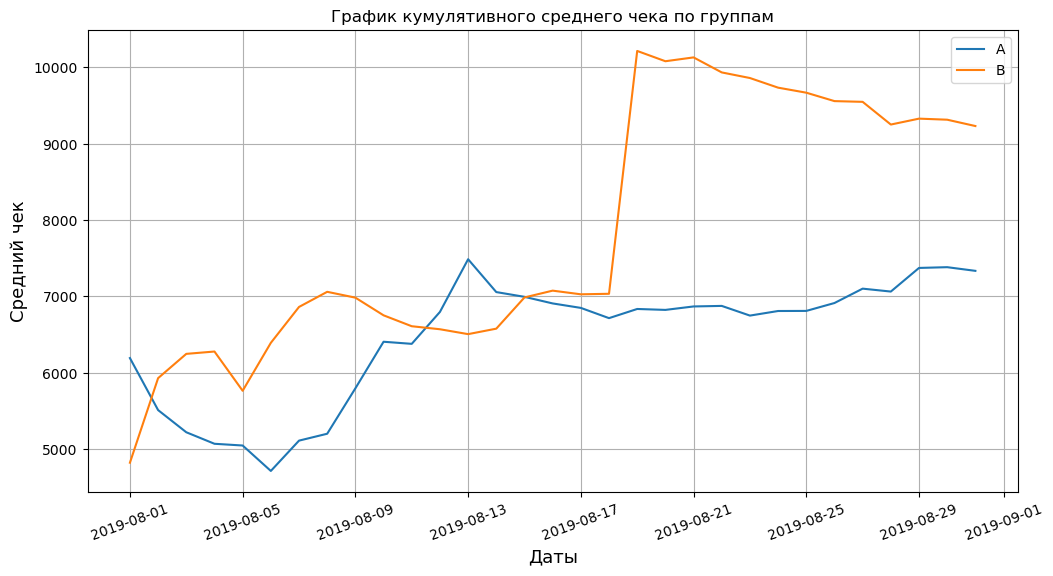

In [27]:

plt.figure(figsize=(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation=20)
plt.xlabel('Даты',fontsize=13)
plt.ylabel('Средний чек',fontsize=13);

**Группа В в первых днях и 13 числа уступает А, далее практически везде предосходит. Видим аномально большой заказ 18 числа. После этого средний чек группы В постепенно падает.**

### График относительного изменения кумулятивного среднего чека группы B к группе A.

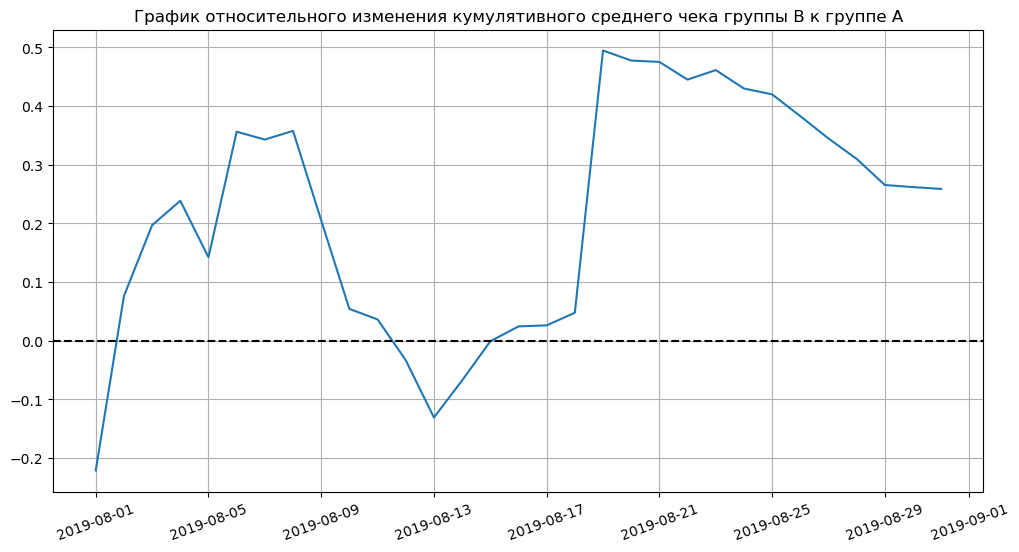

In [28]:
plt.figure(figsize=(12, 6))
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=20);

**График колеблется и однозначно вывод сделать сложно, видим, что большую часть времени группа В лучше группы А. Но в чеках есть аномальные заказы, они смазывают картину.**

### График кумулятивного среднего количества заказов по группам.

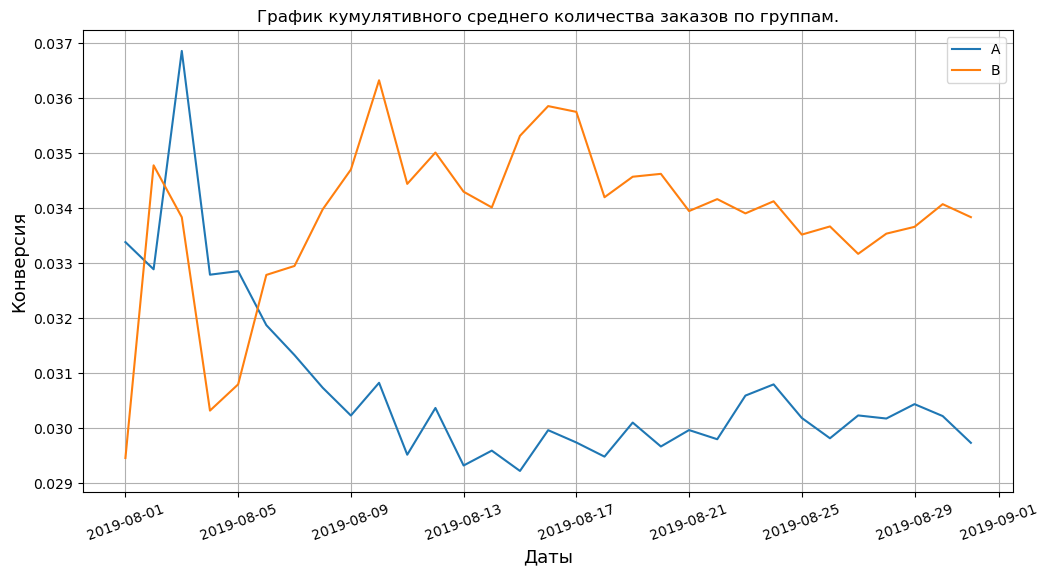

In [29]:

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'],label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.grid()
plt.legend()
plt.title('График кумулятивного среднего количества заказов по группам.')
plt.xticks(rotation=20)
plt.xlabel('Даты',fontsize=13)
plt.ylabel('Конверсия',fontsize=13);

**В начале группа В уступала группе А, но позже вырвалась вперед и превосходила группу А. К концу месяца оба графика стабилизировались.**

### График относительного изменения кумулятивного среднего количества заказов группы B к группе A.

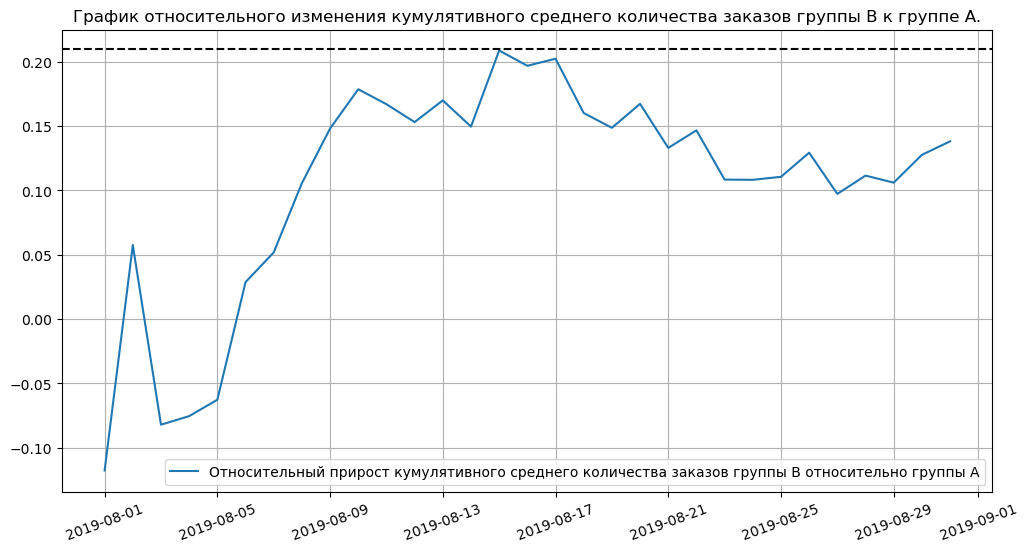

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],
      left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
        label="Относительный прирост кумулятивного среднего количества заказов группы B относительно группы A")


plt.grid()
plt.legend()
plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A.')
plt.xticks(rotation=20)
plt.axhline(y=0.21, color='black', linestyle='--'); 

**Группа В уступая в первых числах, в дальнейшем показывает себя намного лучше, в пике показывая конверсию до 21%, по сравнению с группой А.**

### Точечный график количества заказов по пользователям

In [31]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(15)


,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


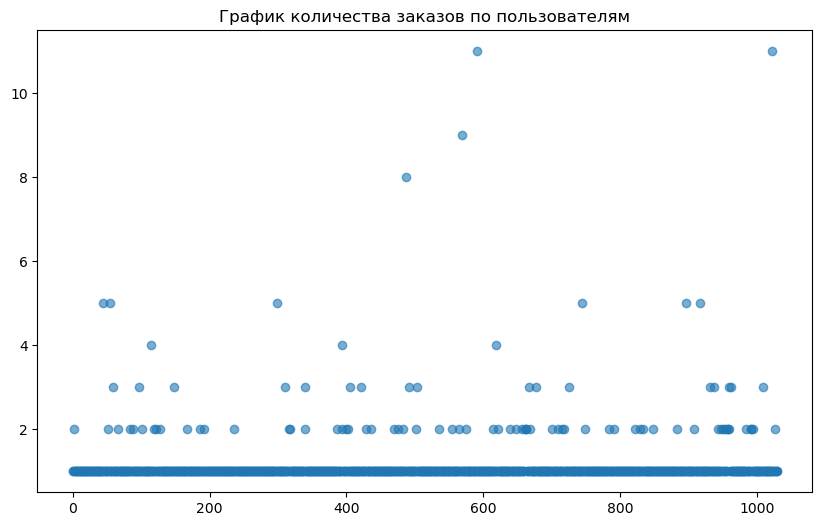

In [32]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(10, 6))
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.6);

**Пользователей сделавших 5 и более заказов совсем мало. Они вполне могут быть аномалиями.**

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя

In [33]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 97, 98, 99.])) 

[1. 2. 2. 3. 4.]


**97% пользователей совершили 2 и менее заказа, 3 и более заказа совершили лишь 2% пользователей. Будем считать пользователей совершивших 3 и более заказов аномальными.**

### Точечный график стоимостей заказов

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))
orders2 = orders.query('revenue < 100000')
x_values2 = pd.Series(range(0,len(orders2['revenue'])))

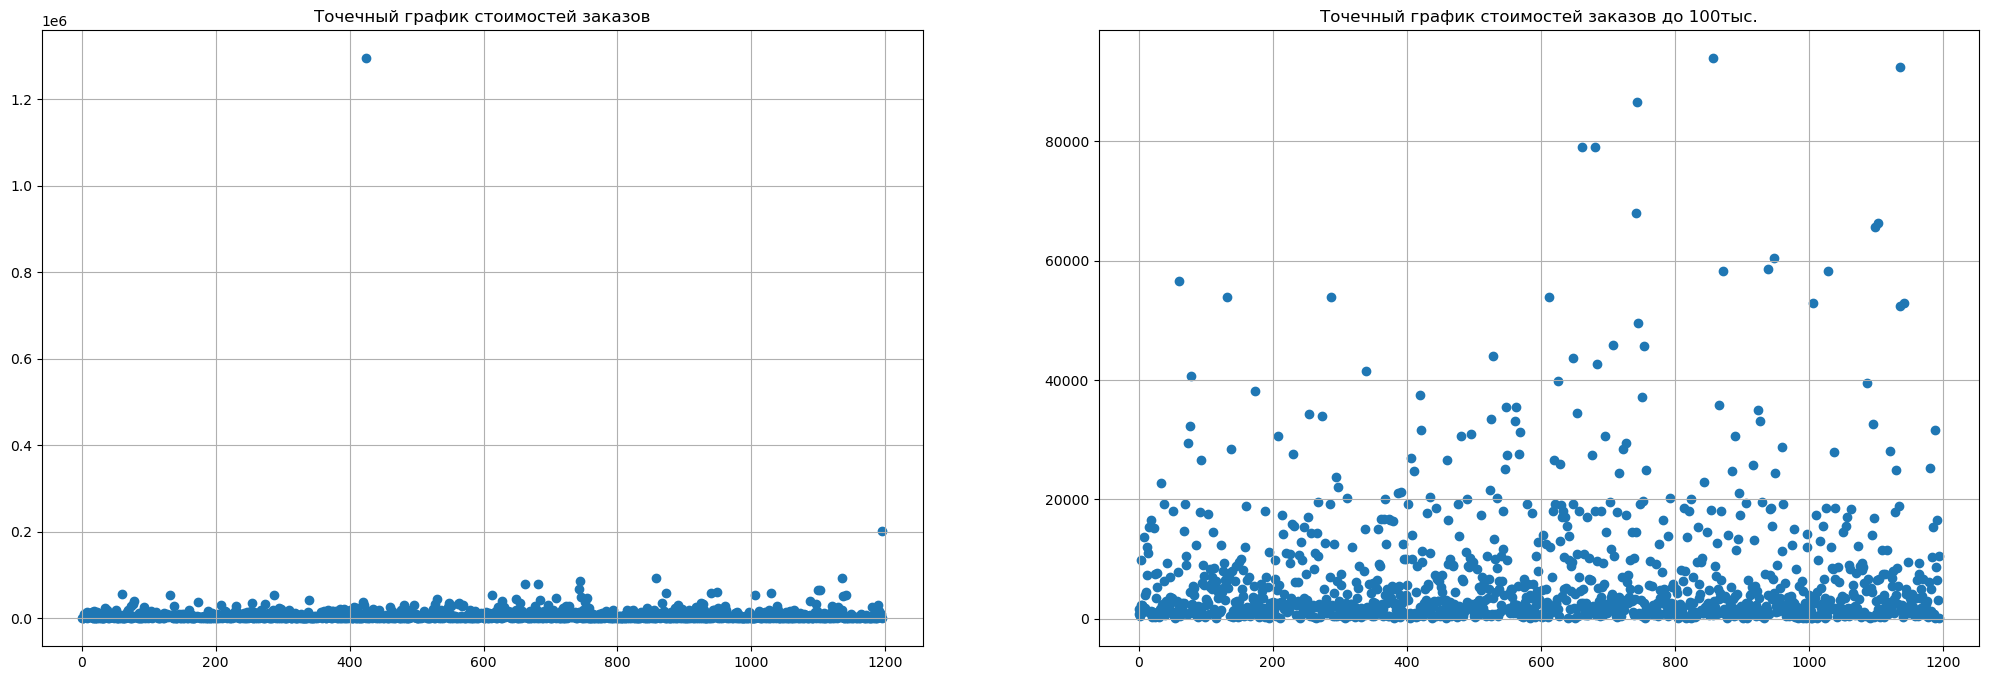

In [35]:
fig, axis = plt.subplots(1, 2, figsize=(25, 8))

axis[0].scatter(x_values, orders['revenue'])
axis[0].set_title('Точечный график стоимостей заказов')
axis[0].grid()

axis[1].scatter(x_values2, orders2['revenue'])
axis[1].set_title('Точечный график стоимостей заказов до 100тыс.')
axis[1].grid()

**По графикам видим, что большая часть, это заказы до 100 тыс. у.е. Основная масса находиться в пределах 40тыс. Так же видим один заказ на 1.3млн.**

#### Посчитайте 95-й и 99-й перцентили стоимости заказов

In [36]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


**95% пользователей совершили заказов на сумму 28тыс. и менее. Лишь 1% заказов превышает 58тыс. Границу можно взять в размере 28 тыс.**

### Посчитайте статистическую значимость различия среднего количества заказов между группами по "сырым" данным.

**Для расчета статистической значимости используем непараметрический тест Уилкоксона-Манна-Уитни. Критический уровень статистической значимости alpha = 0.05.** 

**Сформулируем гипотезы.** 
- Нулевая: различий в среднем количестве заказов между группами нет. 
- Альтернативная: различия в среднем между группами есть.

In [37]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA']
                            .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB']
                            .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


print('Критический уровень статистической значимости alpha = 0.05')
print('P-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост среднего количества заказов группы B к А:', 
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Критический уровень статистической значимости alpha = 0.05
P-value: 0.01679
Относительный прирост среднего количества заказов группы B к А: 0.138


**P-value меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" показал, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13,8%.**

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по "сырым" данным.

**Сформулируем гипотезы.**  
- Нулевая гипотеза: различий в среднем чеке между группами нет. 
- Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [38]:
print('Критический уровень статистической значимости alpha = 0.05')
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительный показатель среднего чека группы B к А:',
    '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Критический уровень статистической значимости alpha = 0.05
P-value: 0.729
Относительный показатель среднего чека группы B к А: 0.259


**P-value больше 0.05. Значит, причин отвергать нулевую гипотезу нет. Статистически значимых отличий в среднем чеке между группами нет. То есть средние чеки по "сырым" данным схожи. Но при этом мы видим отностиельный показатель в 25.9%, с большой вероятностью это обусловлено наличием единичных аномальных значений.**

### Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным.

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('Критический уровень статистической значимости alpha = 0.05')
print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего количества заказов группы B к А:',
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Критический уровень статистической значимости alpha = 0.05
P-value: 0.01304
Относительный прирост среднего количества заказов группы B к А: 0.173


**По сравнению с "сырыми данными" статистическая значимость различий в среднем количестве заказов между группами выросла на 3% процентных пункта.**

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [40]:
print('Критический уровень статистической значимости alpha = 0.05')
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный показатель среднего чека группы B к А:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Критический уровень статистической значимости alpha = 0.05
P-value: 0.738
Относительный показатель среднего чека группы B к А: -0.020


**P-value практически не изменился. Статистически значимых отличий в среднем чеке между группами по «очищенным» данным нет. Зато изменился средний чек группы В к группе А, он стал на 2% меньше, хотя был на 26% больше. Это можно свзять с тем, что в группе В был аномально большой заказ (на 1.3млн) который мы видели на графиках выше, что и повлияло на такой разброс между тестами.**

## Выводы


В резултате проведенных изысканий можно сделать следующие выводы:
- Есть статистически значимое различие по конверсии между группами В и А как по сырым данным, так и по очищенным, 13% и 17% соответственно.
- По сырым данным статистически значимого различия по среднему чеку между группами В и А нет, т.е. можно сделать вывод, что чеки похожи.После удаления аномалий срежние чеки почти сравнялись.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A, в пике достигали 21%, и зафиксировались на уровне 12%.  

Исходя из вышеизложенного, можно считать тест успешным, остановить тест и зафиксировать победу группы В. Конверсия группы В выше, а средний чек примерно одинаковый.